In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from alpha_vantage.timeseries import TimeSeries
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import warnings
warnings.filterwarnings("ignore")
import matplotlib 
matplotlib.rcParams['figure.figsize']= (16, 8)

print('setup completo')



setup completo


In [3]:
ALPHAVANTAGE_API_KEY = 'Insert you key'

In [4]:
ts = TimeSeries(key=ALPHAVANTAGE_API_KEY, output_format='pandas')

In [5]:
ts.get_symbol_search('Bov')

(                                1. symbol  \
 date                                        
 1970-01-01 00:00:00.000000000     BOV.FRK   
 1970-01-01 00:00:00.000000001       BOVNF   
 1970-01-01 00:00:00.000000002  BOVA11.SAO   
 1970-01-01 00:00:00.000000003  BOVB11.SAO   
 1970-01-01 00:00:00.000000004  BOVV11.SAO   
 1970-01-01 00:00:00.000000005  BOVX11.SAO   
 1970-01-01 00:00:00.000000006    INDX.SAO   
 
                                                              2. name 3. type  \
 date                                                                           
 1970-01-01 00:00:00.000000000               Apyx Medical Corporation  Equity   
 1970-01-01 00:00:00.000000001             BioInvent International AB  Equity   
 1970-01-01 00:00:00.000000002            iShares Ibovespa Index Fund     ETF   
 1970-01-01 00:00:00.000000003  ETF Bradesco Ibovespa Fundo De Indice     ETF   
 1970-01-01 00:00:00.000000004        It Now Ibovespa Fundo de Indice     ETF   
 1970-01-01 00:00

In [6]:
dados = ts.get_daily(symbol='BOVA11.SAO', outputsize='full')

In [7]:
serie = dados[0]

In [8]:
serie.head()

,1. open,2. high,3. low,4. close,5. volume
date,,,,,
2022-04-22,109.37,109.37,106.50,106.75,7663244.0
2022-04-20,110.52,110.75,109.73,110.05,3660925.0
2022-04-19,110.76,111.17,110.06,110.92,4193297.0
2022-04-18,111.62,111.98,110.92,111.46,3828777.0
2022-04-14,112.00,112.46,111.30,111.65,3129072.0


In [9]:
serie_close = serie['4. close']

In [10]:
ts_close = serie_close[:100]

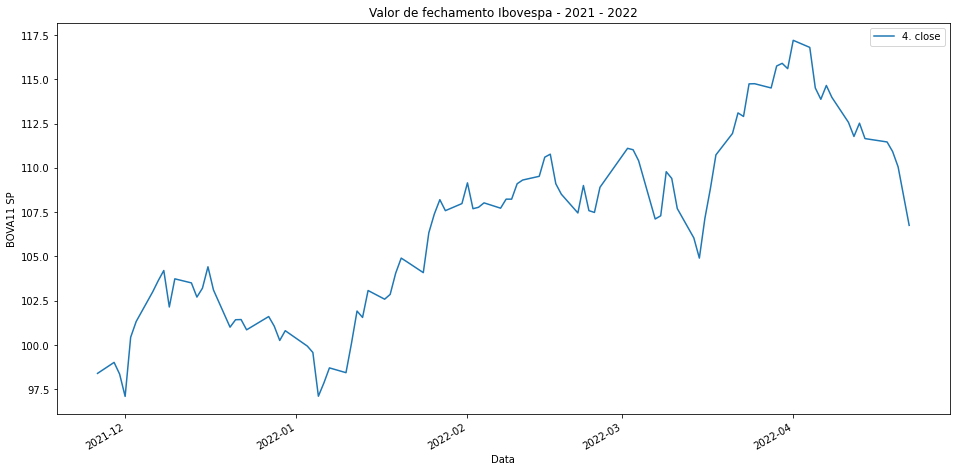

In [11]:
ts_close.plot()
plt.title('Valor de fechamento Ibovespa - 2021 - 2022')
plt.xlabel('Data')
plt.ylabel('BOVA11 SP')
plt.legend(loc='best')

In [12]:
#DETERMINAR A MÉDIA MÓVEL E DESVIO PADRÃO (OPCIONAL)
media_mov = ts_close.rolling(window=3).mean()
#ep_mov = ts_close.rolling(window=12).std()

Text(0.5, 1.0, 'Média Móvel')

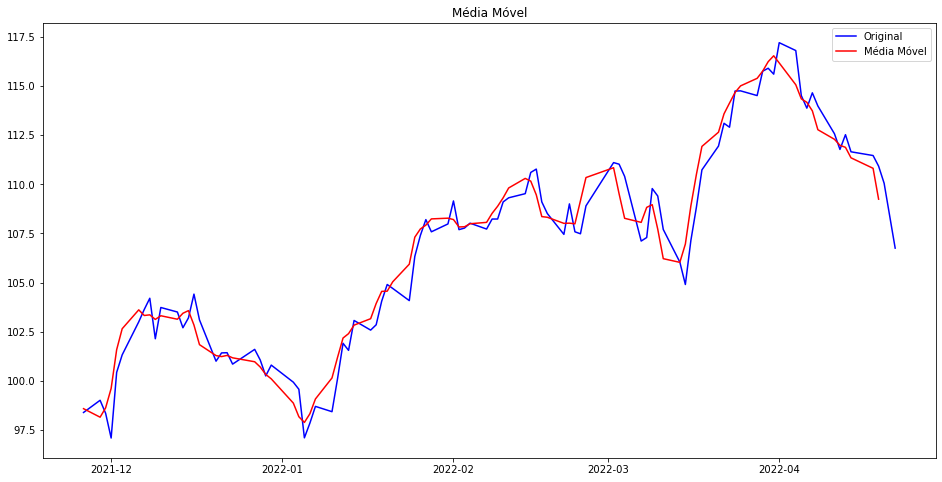

In [13]:
plt.plot(ts_close, color='blue', label='Original')
plt.plot(media_mov, color='red', label='Média Móvel')
#plt.plot(ep_mov, color='green', label='Desvio Padrão Móvel')
plt.legend(loc='best')
plt.title('Média Móvel')


In [14]:
#Teste de estacionaridade

def test_stationarity(timeseries):
    
    #Determinar média móvel
    media_mov = timeseries.rolling(window=12).mean()
    
    
    #Plotar valores
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(media_mov, color='red', label='Média Móvel')
    plt.legend(loc='best')
    plt.title('Média Móvel')
    
    
    #Executar teste Dickey–Fuller:
    print('Resultados teste Dick-Fuller:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-valor','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return orig, mean, dfoutput

Resultados teste Dick-Fuller:


([<matplotlib.lines.Line2D at 0x1cc5e03f490>],
 Test Statistic                 -0.643245
 p-valor                         0.860908
 #Lags Used                      0.000000
 Number of Observations Used    99.000000
 Critical Value (1%)            -3.498198
 Critical Value (5%)            -2.891208
 Critical Value (10%)           -2.582596
 dtype: float64)

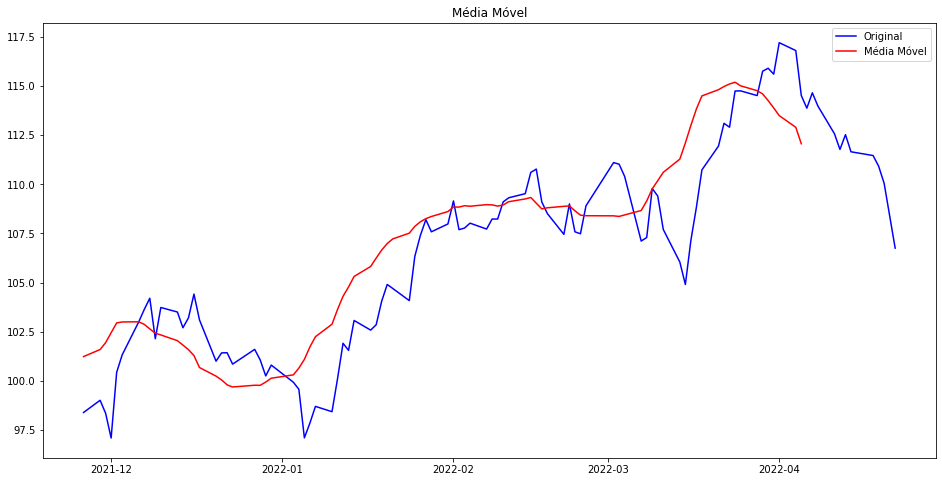

In [15]:
test_stationarity(ts_close)

#O resultando aponta para um p-valor acima de 0.05, indicando que a série é não estacionaria

Resultados teste Dick-Fuller:


([<matplotlib.lines.Line2D at 0x1cc5e460280>],
 Test Statistic                -9.150459e+00
 p-valor                        2.695340e-15
 #Lags Used                     0.000000e+00
 Number of Observations Used    9.800000e+01
 Critical Value (1%)           -3.498910e+00
 Critical Value (5%)           -2.891516e+00
 Critical Value (10%)          -2.582760e+00
 dtype: float64)

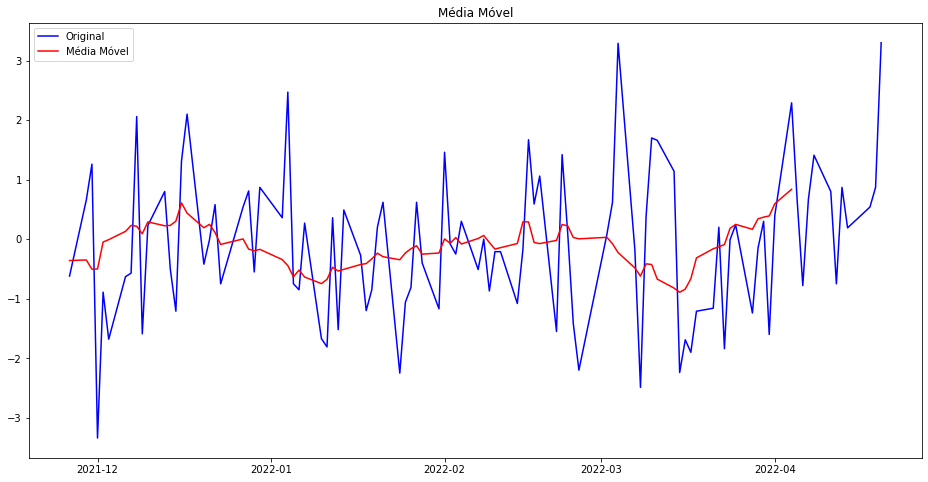

In [16]:
#Colocar em primeira diferença e tirar valores NA
#Testar nova série
#Agora é estacionária
ts_close_diff = ts_close.diff() 
ts_close_diff.dropna(inplace=True)
test_stationarity(ts_close_diff)

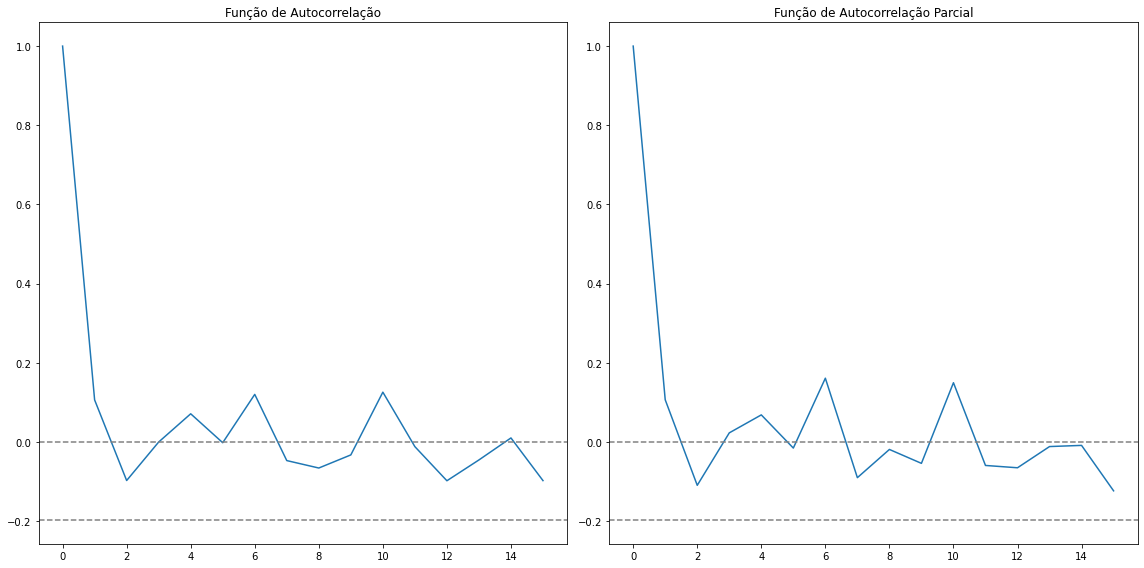

In [17]:
#FUNÇÕES ACF E PACF - DETERMINAR ORDEM DO ARIMA

lag_acf = acf(ts_close_diff, nlags=15)
lag_pacf = pacf(ts_close_diff, nlags=15, method='ols')

#plotando

plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color ='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_close_diff)), linestyle='--', color='gray')
plt.title('Função de Autocorrelação')


plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color ='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_close_diff)), linestyle='--', color='gray')
plt.title('Função de Autocorrelação Parcial')

plt.tight_layout()

In [18]:
model = ARIMA(ts_close_diff, order=(0,1,1))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:             D.4. close   No. Observations:                   98
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -162.401
Method:                       css-mle   S.D. of innovations              1.240
Date:                Sat, 23 Apr 2022   AIC                            330.802
Time:                        08:06:16   BIC                            338.557
Sample:                             1   HQIC                           333.938
                                                                              
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0052      0.004     -1.197      0.231      -0.014       0.003
ma.L1.D.4. close    -1.0000      0.037    -26.970      0.000      -1.073      -0.927
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

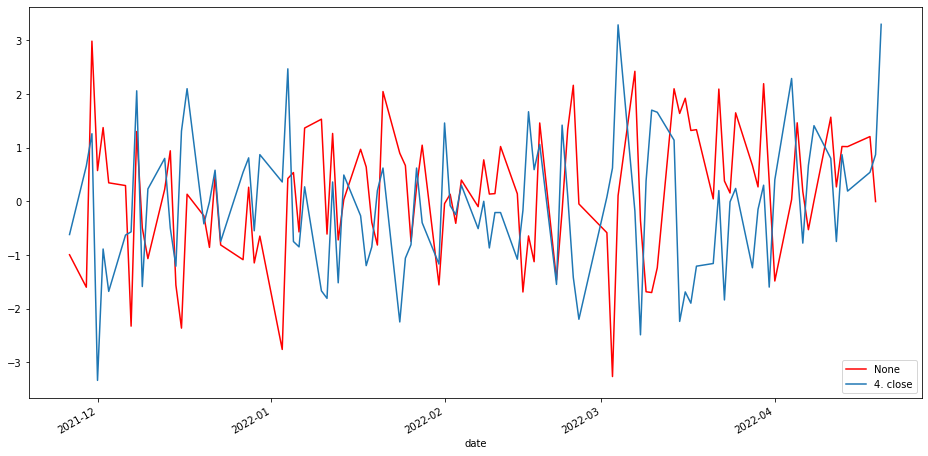

In [20]:
model_fit.fittedvalues.plot(color= 'red')
ts_close_diff.plot()
plt.legend()

#model_fit.plot_predict(dynamic=False)


In [217]:
resid = model_fit.resid

<AxesSubplot:xlabel='date'>

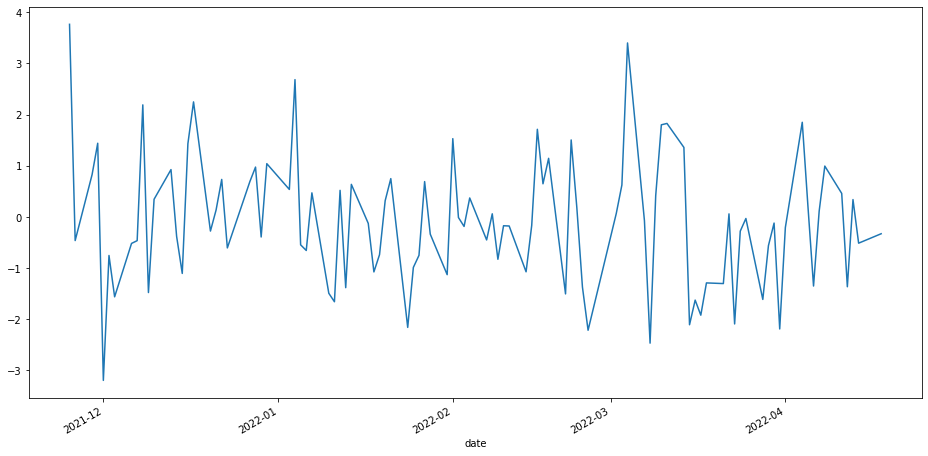

In [218]:
resid.plot()

Resultados teste Dick-Fuller:


([<matplotlib.lines.Line2D at 0x161243a3040>],
 Test Statistic                -8.604186e+00
 p-valor                        6.741800e-14
 #Lags Used                     0.000000e+00
 Number of Observations Used    9.700000e+01
 Critical Value (1%)           -3.499637e+00
 Critical Value (5%)           -2.891831e+00
 Critical Value (10%)          -2.582928e+00
 dtype: float64)

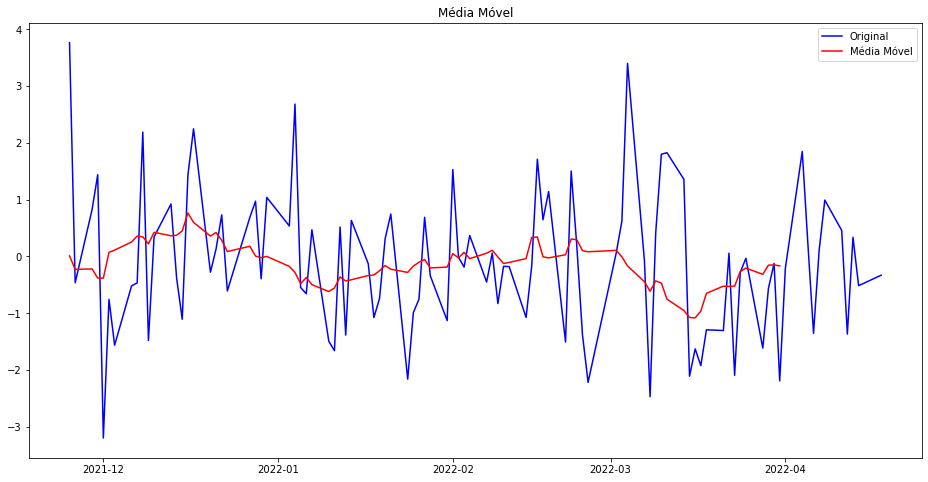

In [219]:
#OS RESIDUOS SÃO ESTACIONÁRIOS, NESSE CASO PODEMOS CONFIAR NA ROBUSTEZ DO MODELO
test_stationarity(resid)

In [220]:
forecast = model_fit.predict()

In [265]:
df = pd.DataFrame(ts_close_diff)


DatetimeIndex(['2022-04-19', '2022-04-18', '2022-04-14', '2022-04-13',
               '2022-04-12', '2022-04-11', '2022-04-08', '2022-04-07',
               '2022-04-06', '2022-04-05', '2022-04-04', '2022-04-01',
               '2022-03-31', '2022-03-30', '2022-03-29', '2022-03-28',
               '2022-03-25', '2022-03-24', '2022-03-23', '2022-03-22',
               '2022-03-21', '2022-03-18', '2022-03-17', '2022-03-16',
               '2022-03-15', '2022-03-14', '2022-03-11', '2022-03-10',
               '2022-03-09', '2022-03-08', '2022-03-07', '2022-03-04',
               '2022-03-03', '2022-03-02', '2022-02-25', '2022-02-24',
               '2022-02-23', '2022-02-22', '2022-02-21', '2022-02-18',
               '2022-02-17', '2022-02-16', '2022-02-15', '2022-02-14',
               '2022-02-11', '2022-02-10', '2022-02-09', '2022-02-08',
               '2022-02-07', '2022-02-04', '2022-02-03', '2022-02-02',
               '2022-02-01', '2022-01-31', '2022-01-28', '2022-01-27',
      

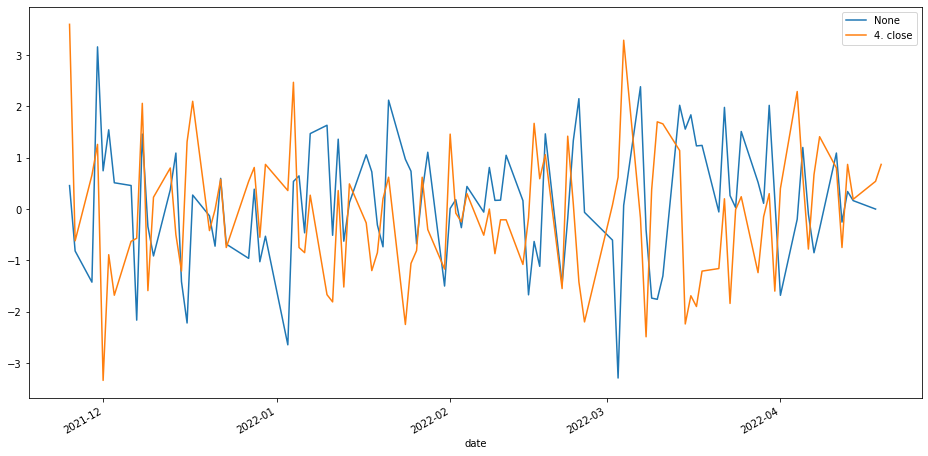

In [224]:


forecast.plot()
ts_close_diff.plot()
plt.legend()





In [84]:
# Create Training and Test
train = pd.DataFrame(ts_close_diff[15:100])
test = pd.DataFrame(ts_close_diff[:15])

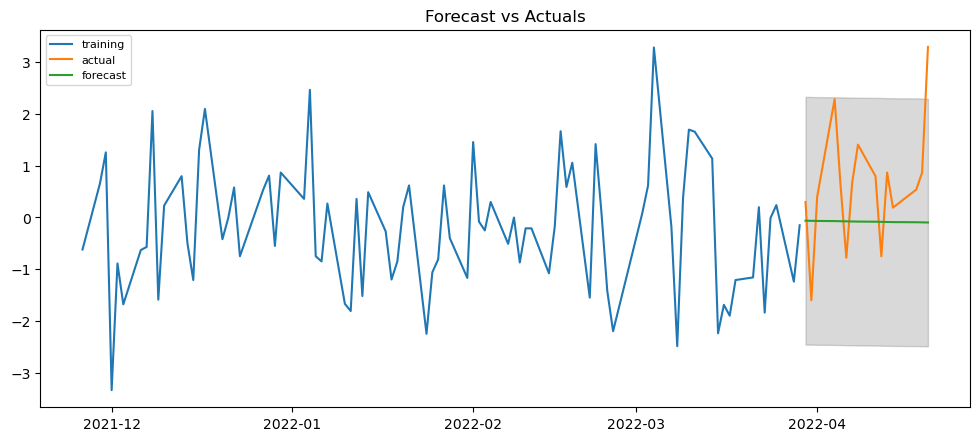

In [90]:
# Build Model
# model = ARIMA(train, order=(3,2,1))  
model = ARIMA(train, order=(0, 1, 1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(15, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()
